### Building an Agentic Application with Ability to Generate and Execute Code 
 
Large Language Models (LLMs) such as OpenAI o1 can generate sophisticated code, making them highly valuable for tasks such as AI assisted programming. Taking this a step further by providing the LLM with the ability to execute the code and examine its output to accomplish a task opens up a whole new paradigm of possibilities. 


In this Cookbook, we will demonstrate implementation of an Agentic application that can generate and execute code to accomplish a given task. There are many potential applications of such an Agentic application, such as: 

1. Data analysis and Visualization 
2. Data manipulation and Transformation 
3. Generating and Execution Machine Learning workloads 
4. Process automation and Scription 
5. ... and many more that will surface as we experiment with these agents

This Cookbook will focus on the first application as listed here - Data Analysis and Visualization - using Python code generated by LLM executed in an isolated sandbox environment.    

#### ⚠️ WARNING:        
##### LLMs could generate unsafe and harmful code with unintended consequences. As a best practice, isolate the code execution environment with only required access to resources as needed by the task. This Cookbook will demonstrate an option to accomplish this goal using Docker to create a sandbox environment for code execution.

The general steps to create an Agentic application with access to a code interpreter tool are:

##### Step 1: Set up an isolated Python code execution environment 
We will create a Docker container environment, with limited access to resources (such as no network access). By default, the containerized environment cannot access the file system of the host system. We will take advantage of this property to contain the code execution so LLM generated code cannot access the host system (my laptop) in this case.

Set up and pre-configure the code execution environment with tools and libraries needed by the LLM generated code. In this example we will install Python and common data analysis and visualization libraries.   

##### Step 2: Define and Test the Agents 
For our purposes, we will define two Agents. An agent is a prompt + tool call. The tool call is a function call to a tool that is defined by the developer. 

Agent 1: Read a file safely and copy it to the docker container. This Agent has access to the file system of the host machine. So it can read the file and copy it to the docker container. However, it DOES NOT have access to the code interpreter to execute any code.  

Agent 2: Generate a Python script to read the file and perform data analysis. This Agent has access to the code interpreter to execute the code. It has access to the file system of the docker container. It DOES NOT have access to the file system of the host machine.

This segregation of the file system and code interpreter is important to ensure that the LLM does not have access to the file system of the host machine (in this case my laptop).

##### Step 3: Set up Agentic Orchestration to run the application 


### Step 1: Set up an Isolated Python Code Execution Environment 

**Prerequisites:**  Docker should be installed and running on your local machine. You can learn more about Docker and [install it from here](https://www.docker.com/). 

**Steps:**
First lets define a Dockerized container environment that will be used to execute our code. We have defined a dockerfile in the directory `resources/docker/dockerfile`. The dockerfile will create an image: 
- Python 3.10 as the base 
- A non-root user 
- Preinstall the packages in requirements.txt  

Contents of the dockerfile:

<div></div>

```dockerfile
FROM python:3.10

RUN apt-get update && \
    apt-get install -y build-essential && \
    rm -rf /var/lib/apt/lists/*

# Create a non-root user
RUN useradd -m sandboxuser
USER sandboxuser
WORKDIR /home/sandboxuser

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

CMD ["python", "--version"]
```
The requirements.txt file contains all the potential packages our LLM generated code may need to accomplish its tasks. This file is copied into the docker container and the packages are installed:
<div></div>

```
numpy
pandas
matplotlib
seaborn
```

We will now build the docker image with the following command. For the sake of brevity, we have redirected the output to grep the success message and print a message if the build fails.

In [ ]:
!docker build -t python_sandbox:latest ./resources/docker 2>&1 | grep -E "View build details|ERROR" || echo "Build failed."

Let's run the container in restricted mode. The container will run in the background. This is our opportunity to define the security policies for the container. It is good practice to only allow the bare minimum features to the container that are required for the task. By default, the container cannot access the host file system from within. Let's also restrict its access to network.  

In [ ]:
# Run the container in restricted mode. The container will run in the background.
!docker run -d --name sandbox --network none --cap-drop all --pids-limit 64 --tmpfs /tmp:rw,size=64M   python_sandbox:latest sleep infinity

Let's make sure container is running using the `docker ps` that should list our container. 

In [ ]:
!docker ps 

### Step 2: Define and Test the Agents

For our purposes, we will define two Agents. An agent is a prompt + tool call. The tool call is a function call to a tool that is defined by the developer. 

Agent 1: Read a file safely and copy it to the docker container. This Agent has access to the file system of the host machine. So it can read the file and copy it to the docker container. However, it DOES NOT have access to the code interpreter to execute any code. This segregation of the file system and code interpreter is important to ensure that the LLM does not have access to the file system of the host machine. 

Agent 2: Generate a Python script to read the file and perform data analysis. This Agent has access to the code interpreter to execute the code. It has access to the file system of the docker container. It DOES NOT have access to the file system of the host machine. 


Let's define a simple Agent. It consists of 
1. Instructions - developer prompt 
2. Access to tool 
3. Ability to call the Completions API 
4. Ability to parse the tool call and execute the function associated with the tool 

For sake of simplicity, these are single task agents and do not have a memory beyond the immediate task. 

Let's define a base agent class that will be used to create the two agents. We start with an abstract base class that enforces a task method signature. This ensures that all concrete agents will implement task consistently.

In [60]:
import json
from abc import ABC, abstractmethod
from typing import Any, Dict, Tuple
from openai import OpenAI
import os
import subprocess
import pandas as pd


client = OpenAI()

class BaseAgent(ABC):
    """
    An abstract base class that defines the interface for all agents.
    Each concrete agent is designed to handle ONE specific function call/tool.
    """
    def __init__(self, developer_prompt: str, model_name: str = "o1"):
        """
        :param developer_prompt: System/developer prompt injected at the beginning of the conversation
        :param model_name: Name of the model to use
        """
        self.developer_prompt = developer_prompt
        self.model_name = model_name
    
    @abstractmethod
    def get_tool_definition(self) -> Dict[str, Any]:
        """
        Return a single tool definition (function definition) that this agent is allowed to use.
        """
        pass

    @abstractmethod
    def handle_tool_call(self, tool_arguments: Dict[str, Any]) -> str:
        """
        Given the model’s request to call the single tool, perform the actual action
        (read a file, execute code, etc.) and return the output as a string.
        """
        pass

    def task(self, user_task: str) -> str:
        """
        Submits a user task/message to the completions API, combined with the developer prompt.
        Returns the completion or result from the tool (if the model calls it).
        """
        # Prepare the messages
        messages = [
            {"role": "system", "content": self.developer_prompt},
            {"role": "user", "content": user_task}
        ]

        # We pass exactly one tool to the API
        single_tool = [self.get_tool_definition()]

        # Send the request
        completion = client.chat.completions.create(
            model=self.model_name,
            messages=messages,
            tools=single_tool  # The model sees only one function to call
        )
        
        # Extract possible function call(s) from the first choice
        tool_calls = completion.choices[0].message.tool_calls

        if tool_calls:
            # We assume the model can only call the single tool we exposed since we only passed one tool to the API
            first_tool_call = tool_calls[0]
            
            # Parse the JSON arguments
            args = json.loads(first_tool_call.function.arguments)
            return self.handle_tool_call(args)
        
        # No tool call, just return text
        return completion.choices[0].message.content

Let's define the FileAccessAgent. We'll define the tool definition and the tool call handler within the class to keep the code organized and coupled. 


In [61]:
class FileAccessAgent(BaseAgent):
    """
    An agent that can only call 'safe_file_access' to read the contents of a file.
    """
    def get_tool_definition(self) -> Dict[str, Any]:
        """
        Returns the single tool (function) this agent can call.
        """
        return ({
                    "type": "function",
                    "function": {
                        "name": "safe_file_access",
                        "description": "Read the contents of a file in a secure manner and transfers it to the Python code interpreter docker container",
                        "parameters": {
                            "type": "object",
                            "properties": {
                                "filename": {
                                    "type": "string",
                                    "description": "Name of the file to read"
                                }
                            },
                            "required": ["filename"]
                        }
                    }
                })

    def handle_tool_call(self, tool_arguments: Dict[str, Any]) -> str:
        """
        Handles the call to 'safe_file_access'.
        """
        filename = tool_arguments["filename"]

        output = self.safe_file_access(filename)

        return output
    
    # Helper function to copy the file to the container
    @staticmethod
    def copy_file_to_container(local_file_name: str, container_name: str = "sandbox") -> str:
        """
        Copies a local file into the home user directory of the specified running container.
        Assumes the container is already running.

        :param local_file_name: Name/path of the file to copy from the host.
        :param container_name: Name of the running container. Default is 'sandbox'.
        """
        container_home_path = "/home/sandboxuser"

        if not os.path.isfile(local_file_name):
            raise FileNotFoundError(f"The local file '{local_file_name}' does not exist.")

        # Construct the docker cp command
        # Format: docker cp <host_path> <container_name>:<container_path>
        container_path = f"{container_name}:{container_home_path}/{os.path.basename(local_file_name)}"

        # Check if the container is running
        check_container_cmd = ["docker", "inspect", "-f", "{{.State.Running}}", container_name]
        result = subprocess.run(check_container_cmd, capture_output=True, text=True)
        
        if result.returncode != 0 or result.stdout.strip() != "true":
            raise RuntimeError(f"The container '{container_name}' is not running.")

        cmd = ["docker", "cp", local_file_name, container_path]
        subprocess.run(cmd, check=True)

        # Verify the file exists in the container after copying
        verify_cmd = ["docker", "exec", container_name, "test", "-f", f"{container_home_path}/{os.path.basename(local_file_name)}"]
        result = subprocess.run(verify_cmd, capture_output=True, text=True)
        
        if result.returncode != 0:
            raise RuntimeError(f"Failed to verify the file '{local_file_name}' in the container '{container_name}'.")

        
        return (f"Copied {local_file_name} into {container_name}:{container_home_path}/.")


    # helper function to read a file safely using pandas
    def safe_file_access(self, filename: str) -> str:
        """
        Read a CSV file safely using pandas.
        Returns the first 6 lines (head) of the CSV file as a string.
        Also copies the file into a Docker container if successful.
        """
        if not filename.endswith('.csv'):
            return "Error: The file is not a CSV file."
        
        # Ensure the file has the directory path associated with it
        if not os.path.dirname(filename):
            filename = os.path.join('./resources/data', filename)
        
        try:
            df = pd.read_csv(filename)
            # Copy the file into the container
            output = self.copy_file_to_container(filename)
            # Return the first 6 rows as a string
            return (output + "\n" + "The file content for the first 6 rows is: \n" + df.head(6).to_string())
        except FileNotFoundError:
            return f"Error: The file '{filename}' was not found in the provided directory."
        except Exception as e:
            return f"Error while reading the CSV file: {str(e)}"
        

Let's test this agent. We'll use Apple 2009-2024.csv file in the resources/data directory. Credits: [Apple Financials 2009-2024](https://www.kaggle.com/datasets/jamiedcollins/hjsjdjdjdjd?resource=download)

In [62]:
file_ingestion_prompt = """
You are a helpful data science assistant. The user will provide the name of a CSV file that contains relational data. The file is in the directory ./resources/data

Instructions:
1. When the user provides the CSV file name, use the 'safe_read_file' tool to read and display the first 6 lines of that file.
2. If the specified file does not exist in the provided directory, return an appropriate error message (e.g., "Error: The specified file does not exist in the provided directory").
3. The user may request data analysis based on the file’s contents, but you should NOT perform or write code for any data analysis. Your only task is to read and return the first 6 lines of the file.

Do not include any additional commentary or code not related to reading the file.
"""  

file_ingestion_agent = FileAccessAgent(file_ingestion_prompt)

file_ingestion_agent_output = file_ingestion_agent.task("Read the file Apple 2009-2024.csv")

print(file_ingestion_agent_output)

Copied resources/data/Apple 2009-2024.csv into sandbox:/home/sandboxuser/.
The file content for the first 6 rows is: 
   year EBITDA (millions) Revenue (millions) Gross Profit (millions) Op Income (millions) Net Income (millions)    EPS Shares Outstanding  Year Close Price Total Assets (millions) Cash on Hand (millions) Long Term Debt (millions) Total Liabilities (millions) Gross Margin  PE ratio Employees
0  2024          $134,661           $391,035                $180,683             $123,216               $93,736  $6.08             15,408          243.0400                $364,980                 $65,171                   $85,750                     $308,030       46.21%     39.97   164,000
1  2023          $125,820           $383,285                $169,148             $114,301               $96,995  $6.13             15,813          191.5919                $352,583                 $61,555                   $95,281                     $290,437       45.03%     29.84   161,000
2  202

Define the second agent that can generate and execute code. 

In [63]:
class PythonExecAgent(BaseAgent):
    """
    An agent that can only call 'execute_python_code' to run Python code in a container.
    """
    def get_tool_definition(self) -> Dict[str, Any]:
        """
        Returns the single tool (function) this agent can call.
        """
        return ({
                    "type": "function",
                    "function": {
                        "name": "execute_python_code",
                        "description": "Executes Python code securely in a container",
                        "parameters": {
                            "type": "object",
                            "properties": {
                                "python_code": {
                                    "type": "string",
                                    "description": "The Python code to execute"
                                }
                            },
                            "required": ["python_code"]
                        }
                    }
                })
    
    def handle_tool_call(self, tool_arguments: Dict[str, Any]) -> str:
        """
        Handles the call to 'execute_python_code'.
        """
        python_code = tool_arguments["python_code"]
        return self.execute_python_code(python_code)

    def execute_python_code(self, code: str) -> str:
        """
        Run Python code in a container and return the output.
        """
        print("[PythonExecAgent] Executing Python code in a container:")
        code = code.strip('"""')
        print(code)
        # Function that actually runs code in a container
        output, errors = self.run_code_in_container(code)
        
        if errors:
            return f"[Error]\n{errors}"
        
        return output

    # Helper function to run code in the container 
    @staticmethod
    def run_code_in_container(code: str, container_name: str = "sandbox") -> Tuple[str, str]:
        # The command we run inside the container uses `python -c` and reads code from stdin.
        # `exec(sys.stdin.read())` executes all code passed via stdin.
        cmd = [
            "docker", "exec", "-i", 
            container_name, 
            "python", "-c", "import sys; exec(sys.stdin.read())"
        ]
        
        # Run the command, providing the code via stdin
        process = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        out, err = process.communicate(code)

        return out, err

In [64]:
data_analysis_prompt = """  
You are a helpful data science assistant. The user will provide:
	1.	The name of a CSV file containing relational data in a table.
	2.	The first 6 lines of the CSV (headers plus sample rows) to clarify column names and data types.
	3.	A question or a task about the data.

Your task is to generate a Python script that:
	1.	Answers the user’s question or task by analyzing the DataFrame.
	2.	Checks if the specified file exists in the current directory before reading. If it does not exist, return an error message:
"Error: The specified file does not exist in the current directory".
	3.	Handles potential mismatches in column names or data types.
	4.	Uses only Python standard libraries plus pandas, numpy, matplotlib, and seaborn.
	5.	Generate only the Python code in a single code block (no explanatory text or comments). 
    6.  Call the tool execute_python_code that will execute the code inside a docker container. 
    7.  Because the code is executed inside a container there is no display attached to the output. 
    8.  Always return the output from the code execution. 
    9.  If the code generates an image or a plot, print the plot as base64 encoded image to stdout. sys.stdout.write(encoded_image). Don't use any extraneous text.
	10.	Put appropriate error handling such as the column names and data types are not as expected.

Files if specified in the prompt are in the directory /home/sandboxuser
"""

data_analysis_agent = PythonExecAgent(data_analysis_prompt)

data_analysis_agent_output = data_analysis_agent.task(f"""What was Apple's revenue in 2024?\n
                                                      {file_ingestion_agent_output}""")

print(data_analysis_agent_output)

[PythonExecAgent] Executing Python code in a container:
import os
import sys
import pandas as pd

filename = "/home/sandboxuser/Apple 2009-2024.csv"

if not os.path.isfile(filename):
    print("Error: The specified file does not exist in the current directory")
    sys.exit(0)

try:
    df = pd.read_csv(filename)
except Exception as e:
    print(f"Error reading the file: {e}")
    sys.exit(0)

# Check for required columns
required_columns = ["year", "Revenue (millions)"]
for col in required_columns:
    if col not in df.columns:
        print(f"Error: Required column '{col}' not found in the data.")
        sys.exit(0)

try:
    row_2024 = df[df['year'] == 2024]
    if row_2024.empty:
        print("No data found for 2024.")
        sys.exit(0)
    revenue_2024 = row_2024["Revenue (millions)"].iloc[0]
except Exception as e:
    print(f"Error processing the data: {e}")
    sys.exit(0)

print(revenue_2024)
$391,035



### Step 3: Set up Agentic Orchestration to run the application 

Let's get a data set with thousands of rows that couldn't possibly fit in the context window of the LLM, and see if our agentic orchestration can handle it with the help of the code interpreter. We will usee APPL.csv file in the resources/data directory. Credits: [Kaggle.com Apple Stock Data](https://www.kaggle.com/datasets/varpit94/apple-stock-data-updated-till-22jun2021)


In [66]:

import base64
import binascii

def is_base64(s):
    try:
        base64.b64decode(s, validate=True)
        return True
    except binascii.Error:
        return False

while True:
    user_input = input("Please enter your question or task. Type 'exit' to stop.     ")
    if user_input == "exit":
        break
    question = user_input

    file_ingestion_agent_output = file_ingestion_agent.task(question)

    print(file_ingestion_agent_output)

    data_analysis_agent = PythonExecAgent(data_analysis_prompt)

    data_analysis_agent_output = data_analysis_agent.task(f"""{question} + "\n" + {file_ingestion_agent_output}""")


    if is_base64(data_analysis_agent_output):
        # decode image
        decoded_image = base64.b64decode(data_analysis_agent_output)
        display(Image(data=decoded_image))
    else:
        # handle text
        print(data_analysis_agent_output)




Copied ./resources/data/AAPL.csv into sandbox:/home/sandboxuser/.
The file content for the first 6 rows is: 
         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100323  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095089  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088110  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090291   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092908   73449600
5  1980-12-19  0.126116  0.126674  0.126116  0.126116   0.098578   48630400


[PythonExecAgent] Executing Python code in a container:
import os
import sys
import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from io import BytesIO

filename = '/home/sandboxuser/AAPL.csv'

if not os.path.isfile(filename):
    sys.stdout.write("Error: The specified file does not exist in the current directory")
    sys.exit(0)

try:
    df = pd.read_csv(filename)
except Exception as e:
    sys.stdout.write(f"Error reading the file: {e}")
    sys.exit(0)

expected_cols = {'Date','Open','High','Low','Close'}
if not expected_cols.issubset(df.columns):
    sys.stdout.write("Error: The required columns are not present or have different names.")
    sys.exit(0)

try:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date','Open','High','Low','Close'], inplace=True)
except Exception as e:
    sys.stdout.write(f"Error converting columns to proper data type: {e}")
    s

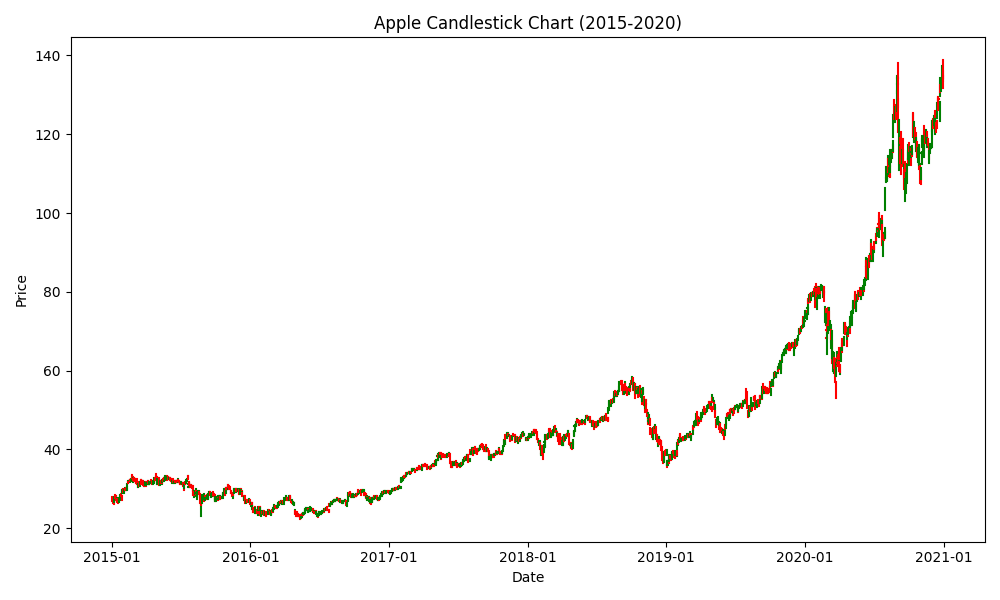

In [67]:
question = "Plot the graph of the Apple stock price using AAPL.csv file for the years 2015 to 2020 with the candlestick chart pattern showing the opening, high, low, and closing prices for each day."


